# Интеллектуальные методы обработки видео

## **ФИО, номер группы:**



Алутис Никита Арвидасович 207

# Ноутбук разделен на два задания:
   * ### [Эвристический SCD](#first)
   * ### [SCD с ML](#second)
   
Сроки выполнения для каждого задания — одна неделя. Оцениваются задания независимо.

## Задание 1. Scene Change Detector
<a id='first'></a>

### Обязательно к прочтению

**Внимание!**

Opencv содержит очень много высокоуровневых функций обработки изображений (например, некоторые алгоритмы компенсации движения, отслеживания объектов, распознавания образов). Использование данной библиотеки в данном задании ограничивается:
* считыванием входного видео
* преобразованием его кадров в другие цветовые пространства
* использованием свёрток Собеля

Использовать библиотеку numpy можно без ограничений.

Если вы хотите использовать функции обработки изображений и видео из другой библиотеки, то оговорите использование этой функции в чате курса.

### Описание входных данных

Выборка для тренировки лежит https://titan.gml-team.ru:5003/sharing/yX8enupJV

Данные о каждом видео лежат в файле *train_dataset\info.json*. Это список из словарей, каждый словарь содержит информацию о расположении видео, о расположении ответов на смены сцен и содержит длину видео

In [520]:
import numpy as np
import cv2 # Для установки opencv воспользуйтесь командой в терминале conda install -c conda-forge opencv
from tqdm import tqdm_notebook as tqdm
from tqdm import notebook 
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [521]:
import json
def load_json_from_file(filename):
    with open(filename, "r") as f:
        return json.load(f, strict=False)


def dump_json_to_file(obj, filename, **kwargs):
    with open(filename, "w") as f:
        json.dump(obj, f, **kwargs)

In [523]:
video_dataset = load_json_from_file('train_dataset/info.json')
video_dataset

[{'source': 'video/03.mp4', 'scene_change': 'gt/03.json', 'len': 3250},
 {'source': 'video/04.mp4', 'scene_change': 'gt/04.json', 'len': 3392},
 {'source': 'video/05.mp4', 'scene_change': 'gt/05.json', 'len': 5662},
 {'source': 'video/07.mp4', 'scene_change': 'gt/07.json', 'len': 3321},
 {'source': 'video/08.mp4', 'scene_change': 'gt/08.json', 'len': 3396},
 {'source': 'video/10.mp4', 'scene_change': 'gt/10.json', 'len': 6096},
 {'source': 'video/14.mp4', 'scene_change': 'gt/14.json', 'len': 2326},
 {'source': 'video/17.mp4', 'scene_change': 'gt/17.json', 'len': 2904},
 {'source': 'video/21.mp4', 'scene_change': 'gt/21.json', 'len': 4898},
 {'source': 'video/22.mp4', 'scene_change': 'gt/22.json', 'len': 7749},
 {'source': 'video/dop1.mp4', 'scene_change': 'gt/dop1.json', 'len': 2411},
 {'source': 'video/dop2.mp4', 'scene_change': 'gt/dop2.json', 'len': 2929},
 {'source': 'video/dop3.mp4', 'scene_change': 'gt/dop3.json', 'len': 2112},
 {'source': 'video/dop4.mp4', 'scene_change': 'gt/do

### Загрузка видео ###

Загрузка видео осуществляется при помощи cv2.VideoCapture. Этот код изменять и дописывать не нужно.

In [502]:
def read_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==False:
            break
        yield frame
    cap.release()

In [7]:
frames = read_video(os.path.join('train_data set', 'video', '21.mp4'))

Что такое frames? Это итератор на кадры видео. Чтобы пройтись по всем кадрам последовательности, воспользуйтесь следующей конструкцией:
*Аккуратно, по одной переменной frames можно пройти только один раз!*

In [9]:
#for frame in tqdm(frames):
 #   pass
#for frame in tqdm(frames): # Второй раз уже не будет итерации
 #   pass

### Пишем свой простой детектор смен сцен

На данном этапе предлагается написать простой Scene Change Detector (SCD) на основе выделения характеристик кадров, подсчёта разницы между кадрами на основе данных характеристик, а также подобрать наиболее оптимальный порог для этих признаков и совместить эти признаки.
Сменой сцен в данной задаче являются только обычные мгновенные смены сцен, без дополнительных эффектов.

В качестве примера приведён простой детектор смен, который считает межкадровую разницу между кадрами.

*Важное замечание. Здесь и далее результатом алгоритма детектора сцен являются **индексы кадров начал сцен**, при этом кадры **нумеруются с 0**. Нулевой кадр в качестве ответа указывать не нужно*

<img src="Hard_cut.jpg">

In [8]:
def baseline_scene_change_detector(frames, threshold=2000, with_vis=False):
    """
    Baseline SCD

    Arguments:
    frames -- iterator on video frames
    threshold -- parameter of your algorithm (optional)
    with_vis -- saving neighboring frames at a scene change (optional)

    Returns:
    scene_changes -- list of scene changes (idx of frames)
    vis -- list of neighboring frames at a scene change (for visualization)
    metric_values -- list of metric values (for visualization)
    """
    
    def pixel_metric(frame, prev_frame):
        # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

    scene_changes = []
    vis = []
    metric_values = []
    prev_frame = None
    for idx, frame in notebook.tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        if prev_frame is not None:
            # Находим расстояние между соседними кадрами
            metric_value = pixel_metric(frame, prev_frame)
            if metric_value > threshold:
                scene_changes.append(idx)
                if with_vis:
                    # Кадры в памяти занимают много места, поэтому сохраним лишь первые 100 срабатываний
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
            metric_values.append(metric_value)
        else:
            metric_values.append(0)
        prev_frame = frame
    return scene_changes, vis, metric_values

In [17]:
frames = read_video(os.path.join('train_dataset', 'video', '21.mp4'))
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '21.json'))['cut']
scene_changes_base, vis_base, metric_values_base = baseline_scene_change_detector(frames, with_vis=True)

Посмотрим визуально, насколько сильно алгоритм ошибается, а также на значения метрики

In [9]:
def visualize_metric_error(frame, prev_frame, value):
    fig = plt.figure(figsize=(16,4))
    plt.suptitle('Значение метрики на текущем кадре: {:.4f}'.format(value), fontsize=24)
    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(prev_frame[:,:,::-1])
    ax.set_title("Предыдущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(frame[:,:,::-1])
    ax.set_title("Текущий кадр", fontsize=18)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(top=0.80)

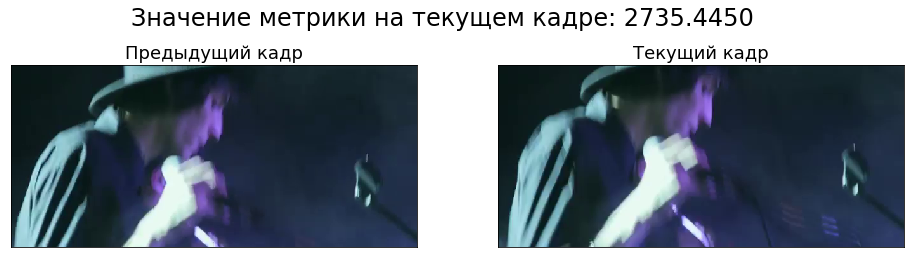

In [19]:
idx = 40
visualize_metric_error(vis_base[idx][0], vis_base[idx][1], metric_values_base[scene_changes_base[idx]])
# смена сцен

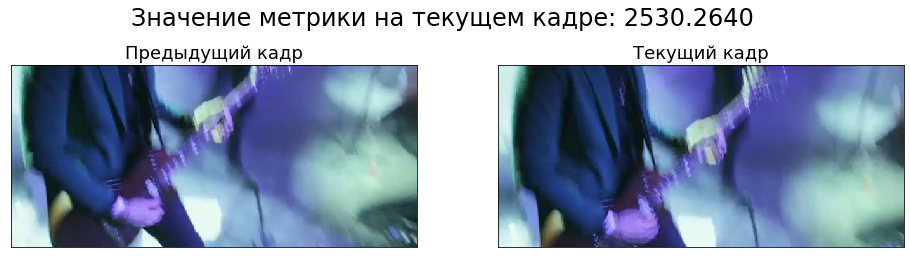

In [20]:
idx = 10
visualize_metric_error(vis_base[idx][0], vis_base[idx][1], metric_values_base[scene_changes_base[idx]])
# ошибается, это не смена сцен

In [10]:
def visualize_metric_values(metric_values, threshold, cuts = None):
    sns.set()
    plt.figure(figsize=(16, 8))
    plt.plot(metric_values, label='Значение метрики на кадрах')
    plt.xlabel('Номер кадра')
    plt.ylabel('Значение метрики')
    plt.hlines(y=threshold, xmin=0, xmax=len(metric_values), linewidth=2, color='r', label='Пороговое значение')
    
    if cuts is not None:
        for cut in cuts:
            plt.axvline(x=cut, color='k', linestyle=':', linewidth=0.5, label='Смена сцены')

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

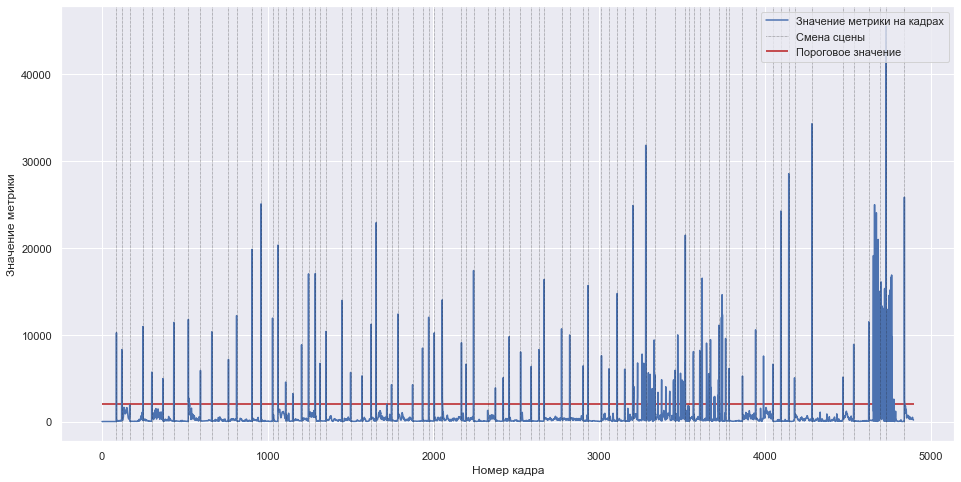

In [22]:
visualize_metric_values(metric_values_base, 2000, cuts_base)

**Как видим, очень плохо подобран порог, да и сам признак, похоже, сильно зашумлён. Попробуйте что-то своё!**

### Ваше решение

* В качестве решения вы должны прикрепить функцию ниже. Все пороги должны быть указаны внутри функции.  
Т.е. должен быть возможен вызов:  
`scene_changes, vis, metric_values = scene_change_detector(frames)`  
* Строку (# GRADED FUNCTION: [function name]) менять **нельзя**. Она будет использоваться при проверке вашего решения.
* Ячейка должна содержать только **одну** функцию.

In [14]:
def get_border(framo):
    sobel = cv2.Sobel(framo,0,0,1)
    sobel2 = cv2.Sobel(framo,0,1,0)
    prevo3 = sobel+sobel2
    return prevo3


def Hist_Differ(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    histr = cv2.calcHist([gray1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([gray2],[0],None,[256],[0,256])
    #must use mean
    return np.mean(np.abs(histr-histr2))

def NewMetric(img1, img2):
    def SobelBorder3(img):
        ddepth = cv2.CV_16S
        scale = 1
        delta = 0
        gray = img
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        return grad
    
    ig1 = SobelBorder3(img1)
    ig2 = SobelBorder3(img2)
    histr = cv2.calcHist([ig1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([ig2],[0],None,[256],[0,256])
    return np.mean(np.abs(histr-histr2))

def pixel_metric3(frame, prev_frame):
    return (np.mean(SobelBorder(frame).astype(np.int32) - SobelBorder(prev_frame)) ** 2) *40

#!!!!
def pixel_metric7(frame, prev_frame):
    im1 = cv2.resize(frame, (200,200))
    im2 = cv2.resize(prev_frame, (200,200))
    return (1 - ssim_metric(im1,im2))
#!!!!

def pixel_metric8(frame, prev_frame):
    im1 = cv2.resize(frame, (128,128))
    im2 = cv2.resize(prev_frame, (128,128))
    img_1 = SobelBorder(im1)
    img_2 = SobelBorder(im2)
    return (1 - ssim_metric(img_1,img_2))




def pixel_metric6(frame, prev_frame):
    res1 = cv2.resize(frame, (200,200),cv2.INTER_NEAREST)
    res2 = cv2.resize(prev_frame, (200,200),cv2.INTER_NEAREST)
    return (np.mean(SobelBorder(res1).astype(np.int32) - SobelBorder(res2)) ** 2) *40

def pixel_metric2(frame, prev_frame):
    return Hist_Differ(frame,prev_frame)

def IsImageGray(img):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if not(img[x,y][0] == img[x,y][1] == img[x,y][2]):
                return False

    return True   

def New_Hist_Differ(img1, img2):
    h1 = SobelBorder(img1)
    h2 = SobelBorder(img2)
    histr = cv2.calcHist([h1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([h2],[0],None,[256],[0,256])
    return cv2.compareHist(histr, histr2, 2)

def pixel_metric(frame, prev_frame):
    # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
    return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

def pixel_metric4(frame, prev_frame):
    init_size_x = 1280
    init_size_y = 720
    multi = 2
    img1_res = cv2.resize(frame, dsize=(init_size_x // multi, init_size_y // multi))
    img2_res = cv2.resize(prev_frame, dsize=(init_size_x // multi, init_size_y // multi))
    sum_err = 0
    def Error(pr1,pr2):
        return (np.mean(pr1 - pr2) ** 2);
    b_s = 40
    for i in range (init_size_x//b_s- 2) :
        for k in range (init_size_y//b_s- 2) :
            test_1 = img1_res[b_s + i*b_s:b_s + (i+1)*(b_s),b_s +k*b_s:b_s +(k+1)*(b_s)]
            new_error = 100000000
            for z1 in range(3):
                for z2 in range(3):
                    test_2 = img2_res[i*b_s + z1 + b_s:(i+1)*(b_s)+ z1 + b_s,b_s +k*b_s+ z2:b_s +(k+1)*(b_s)+ z2]
                    if (Error(test_1,test_2) < new_error):
                        new_error = Error(test_1,test_2)
            sum_err += new_error
    return sum_err


def pixel_metric5(frame, prev_frame):
    res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
    res2 = cv2.resize(prev_frame, (64,64),cv2.INTER_NEAREST)
    return pixel_metric(res1,res2)

def pixel_metric5_prev(frame, prev_frame):
    res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
    return pixel_metric(res1,prev_frame)

def median(image):
    return cv2.medianBlur(image, 5)


def median_pixel_metric(frame, prev_frame):
    return pixel_metric2(median(frame),median(prev_frame))

def upd_metric(fr1, fr2):
    res1 = cv2.resize(fr1, (64,64))
    res2 = cv2.resize(fr2, (64,64))
    return median_pixel_metric(fr1,fr2)

def hist_metric_2_0(img1,img2):
    hist = cv2.calcHist([img1],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])
    return cv2.compareHist(hist, hist2,cv2.HISTCMP_BHATTACHARYYA )

from skimage.metrics import structural_similarity as ssim

def ssim_metric(img1,img2):
    return ssim(img1, img2, multichannel=True)

def SobelBorder(img):
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

def SobelBorder2(img):
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    gray = img
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

def MetricME(im_my1, im_my2):
    init_size_x = 1280
    init_size_y = 720
    multi = 8
    img1_res = cv2.resize(im_my1, dsize=(init_size_x // multi, init_size_y // multi))
    img2_res = cv2.resize(im_my2, dsize=(init_size_x // multi, init_size_y // multi))
    sum_err = 0
    def Error(pr1,pr2):
        return abs(np.sum(pr1 - pr2))

    for i in range (5):
        for k in range (9):
            test_1 = img1_res[i:i+16,k:k+10]
            new_error = 1000000
            for z1 in range(4):
                for z2 in range(4):
                    test_2 = img2_res[min(0,z1 - 32):min(0,z1 - 32)+32,min(0,z2 - 20):min(0,z2 - 20)+10]
                    if (Error(test_1,test_2) < new_error):
                        new_error = Error(test_1,test_2)
            sum_err += new_error
    return sum_err

In [17]:
import itertools

In [120]:
# GRADED FUNCTION: scene_change_detector

def scene_change_detector(frames, threshold=0.5, with_vis=False):
    scene_changes = []
    vis = []
    metric_values = []
    prev_frame = None
    prev_frame2 = None
    prev_frame3 = None
    def pixel_metric2(frame, prev_frame):
        return Hist_Differ(frame,prev_frame)
    prev_gr = None
    prev_exist = False
    gray = False
    st = tqdm(enumerate(frames), leave=False)
    st, copy_it = itertools.tee(st)
    copy_it, copy_it2 = itertools.tee(copy_it)
    gr_count = 0
    summa = 0
    for idx,frame in copy_it:
        summa = idx
        if(idx % 100 == 0):
            if (IsImageGray(frame)):
                gr_count+=1
                
    if (gr_count > summa//128):
        gray = True
        threshold = 1150
    for idx, frame in st:

        np.std(metric_values)
        if (prev_frame is not None) and (prev_frame2 is not None) and (prev_frame3 is not None):
            koef = 0
            if (gray): 
                if (prev_exist):
                    metric_value = pixel_metric5_prev(frame,prev_gr)
                else:
                    metric_value = pixel_metric5(frame,prev_frame)
                    prev_exist = True
                prev_gr = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
                
            else:         
                metric_value = pixel_metric7(frame, prev_frame)
                if ((metric_value > 0.3) and (metric_value < 0.7)):
                    metric_value2 = pixel_metric7(frame, prev_frame2)
                    metric_value = min(metric_value,metric_value2)
                if (Hist_Differ(frame,prev_frame) < 850):
                    metric_value = 0
            if metric_value > threshold:
                scene_changes.append(idx)
                if with_vis:
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
            metric_values.append(metric_value)
        else:
            metric_values.append(0)
        if prev_frame is not None:
            prev_frame2 = prev_frame
        if prev_frame2 is not None:
            prev_frame3 = prev_frame2     
        prev_frame = frame
        pass

    return scene_changes, vis, metric_values

In [157]:
frames = read_video(os.path.join('train_dataset', 'video', '21.mp4'))
cuts = load_json_from_file(os.path.join('train_dataset', 'gt', '21.json'))['cut']
scene_changes, vis, metric_values = scene_change_detector(frames, with_vis=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


In [260]:
print(gr_ssim(vis[8][0],vis[8][1]))

0.0


In [294]:
def gray_sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_sobelh = sobel_h(gray)
    return image_sobelh

def gr_ssim(imagel,image2l):
    iml1 = cv2.resize(imagel, (200,200)) 
    iml2 = cv2.resize(image2l, (200,200))
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5),       sharex=True, sharey=True)
    ax[0,0].imshow(gray_sobel(iml1))
    ax[0,1].imshow(gray_sobel(iml2))
    return 1 - ssim_metric(gray_sobel(iml1),gray_sobel(iml2))

0.3021799591314783


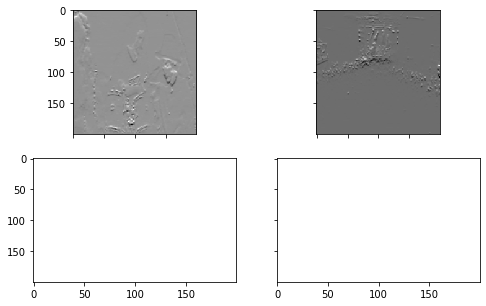

In [299]:
idx = 2
print(gr_ssim(vis[idx][0],vis[idx][1]))

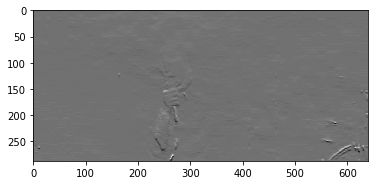

In [293]:
idx = 2
plt.imshow(gray_sobel(vis[idx][0]))

In [197]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


original = vis[8][0]

# sigma = 0.155
# noisy = random_noise(original, var=sigma**2)

# fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
#                        sharex=True, sharey=True)

# plt.gray()

# # Estimate the average noise standard deviation across color channels.
# sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# # Due to clipping in random_noise, the estimate will be a bit smaller than the
# # specified sigma.
# print(f"Estimated Gaussian noise standard deviation = {sigma_est}")

def denoise(image):
    ret = denoise_wavelet(image, multichannel=True, convert2ycbcr=True, rescale_sigma=True)
    return ret


# ax[0, 0].imshow(noisy)
# ax[0, 0].axis('off')
# ax[0, 0].set_title('Noisy')
# ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
# ax[0, 1].axis('off')
# ax[0, 1].set_title('TV')
# ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
#                 multichannel=True))
# ax[0, 2].axis('off')
# ax[0, 2].set_title('Bilateral')
# ax[0, 3].imshow(denoise_wavelet(original, multichannel=True, rescale_sigma=True))
# ax[0, 3].axis('off')
# ax[0, 3].set_title('Wavelet denoising')

# ax[1, 1].imshow(denoise_tv_chambolle(original, weight=0.2, multichannel=True))
# ax[1, 1].axis('off')
# ax[1, 1].set_title('(more) TV')
# ax[1, 2].imshow(denoise_bilateral(original, sigma_color=0.1, sigma_spatial=15,
#                 multichannel=True))
# ax[1, 2].axis('off')
# ax[1, 2].set_title('(more) Bilateral')
# ax[1, 3].imshow(denoise_wavelet(original, multichannel=True, convert2ycbcr=True,
#                                 rescale_sigma=True))
# ax[1, 3].axis('off')
# ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
# ax[1, 0].imshow(original)
# ax[1, 0].axis('off')
# ax[1, 0].set_title('Original')

# fig.tight_layout()

# plt.show()

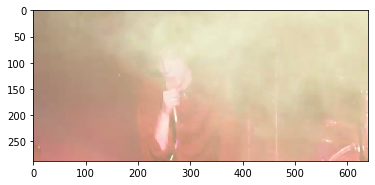

In [190]:
plt.imshow(original/255)

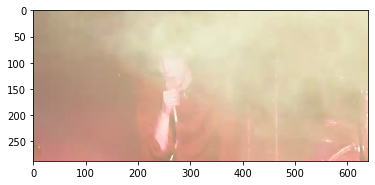

In [184]:
plt.imshow(denoise(original))

In [ ]:
зк

In [194]:
res1 = cv2.resize(original, (64,64))

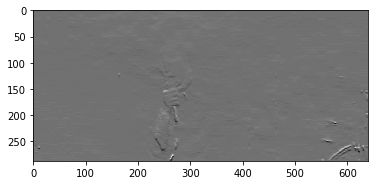

In [203]:
from skimage.filters import sobel_h

gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

image_sobelh = sobel_h(gray)

plt.imshow(image_sobelh)

def gray_sobel(image):
    gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    image_sobelh = sobel_h(gray)
    return image_sobelh
    

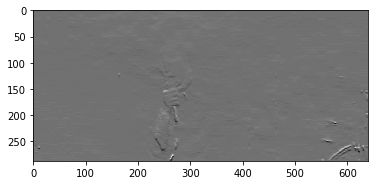

In [204]:
plt.imshow(res1)

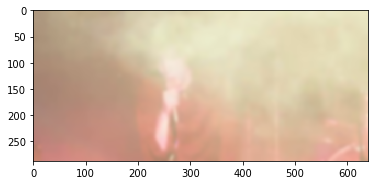

In [211]:
import skimage

def blur2(image):
    ret = skimage.filters.gaussian(image, sigma=(3, 3), truncate=3.5, multichannel=True)
    return ret

plt.imshow(blur2(original))

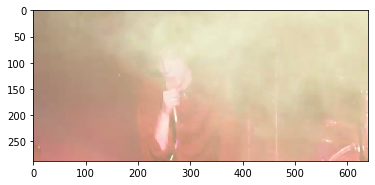

In [210]:
plt.imshow(original)

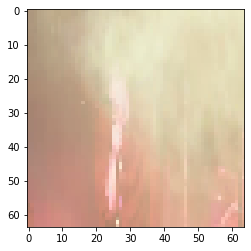

In [199]:
plt.imshow(denoise(res1))

In [ ]:
   def blur_ssim(image,image2):
    pixel_metric7(blur2(image),blur2(image2))

)

In [191]:
original.dtype

dtype('uint8')

In [192]:
np.sum(denoise(original) - original/255)

-0.2979323776685544

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


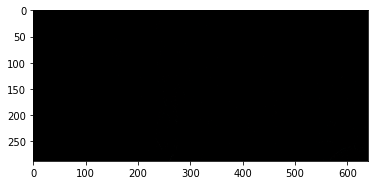

In [193]:
plt.imshow(original/255 - denoise(original))

601.21875
229.6696508563301
165.62190209733114
32.4365234375
1297.4609
1298.9453
0.8015853660124723
0.8958909862463947


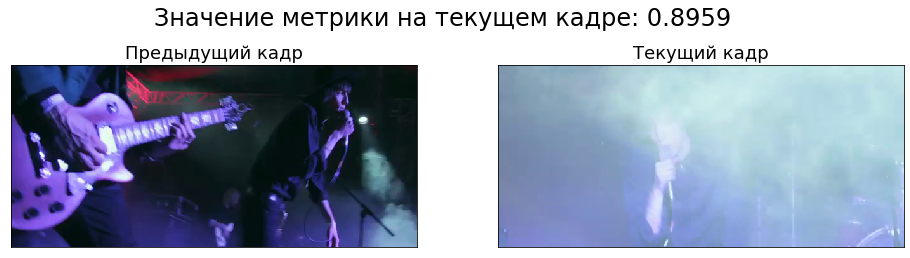

In [119]:
idx = 8
visualize_metric_error(vis[idx][0], vis[idx][1], metric_values[scene_changes[idx]])
print(NewMetric(vis[idx][0],vis[idx][1] ))
print(pixel_metric3(vis[idx][0],vis[idx][1] ) / 40)
print(pixel_metric3(median(vis[idx][0]),median(vis[idx][1]) ) / 40)
print(pixel_metric2(vis[idx][0],vis[idx][1] ) / 40)
print(Hist_Differ(vis[idx][0],vis[idx][1] ))
print(upd_metric(vis[idx][0],vis[idx][1] ))
print(hist_metric_2_0(vis[idx][0],vis[idx][1] ))
print(pixel_metric7(vis[idx][0],vis[idx][1] ))
#print(Me3ricME(vis[idx][0],vis[idx][1] ))
#print(IsImageGray(vis[8][0]))

In [ ]:
339.10156
3.714193858511655
2.956265315774046
35.9974609375
1439.8984
1440.0
0.9878932771904461
0.7551250888741604

In [771]:
image = vis[idx][0]
image2 = vis[idx][1]

In [772]:
res1 = cv2.resize(image, (64,64))
res2 = cv2.resize(image2, (64,64))

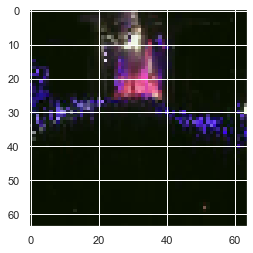

In [773]:
plt.imshow(res1)

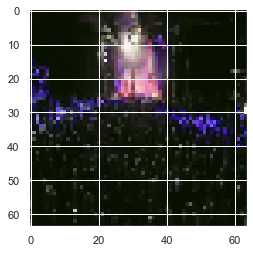

In [774]:
plt.imshow(res2)

In [777]:
hist = cv2.calcHist([res1],[0],None,[256],[0,256])
hist2 = cv2.calcHist([res2],[0],None,[256],[0,256])

In [780]:
cv2.compareHist(hist, hist2,cv2.HISTCMP_CHISQR)

0.2786173147512894

In [19]:
def hist_metric_2_0(img1,img2):
    res1 = cv2.resize(image, (128,128))
    res2 = cv2.resize(image2, (128,128))
    hist = cv2.calcHist([res1],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([res2],[0],None,[256],[0,256])
    return cv2.compareHist(hist, hist2,cv2.HISTCMP_CHISQR)

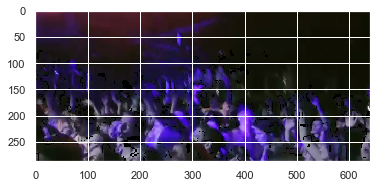

In [585]:
height, width = image.shape[0:2]
for i in range(0, height):
    for j in range(0, width):
        if ((image[i][j][0] * 255 == image[i][j][1] * 255 == image[i][j][2] * 255) or (
                (image[i][j][0] * 255 == image[i][j][1] * 255) and (
                image[i][j][2] * 255 >= 245))):
            image[i][j] = 0


plt.imshow(image)

In [601]:
image = vis[idx][0]

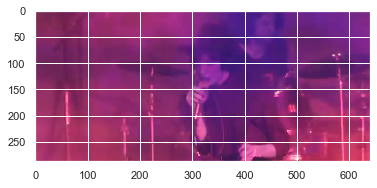

In [602]:
plt.imshow(image)

In [624]:
median = cv2.medianBlur(image, 5)

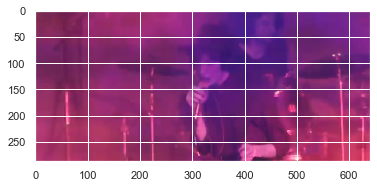

In [623]:
plt.imshow(median)

In [612]:
gray_image = SobelBorder(image)

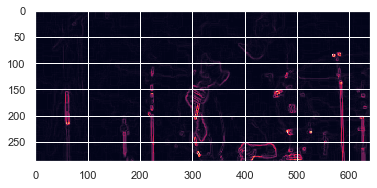

In [613]:
plt.imshow(gray_image)

In [614]:
gray_image2 = SobelBorder(median)

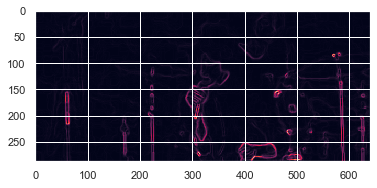

In [615]:
plt.imshow(gray_image2)

In [608]:
median2 = cv2.medianBlur(gray_image, 5)

## 291.82812
208.05135655229475
11.7162109375

In [335]:
print(pixel_metric3(vis[25][0], vis[25][1]))

136.01193535138353


In [ ]:
#пробовал работать с хеш-функциями

In [491]:
def dhash(image, hashSize=32):
    resized = cv2.resize(image, (hashSize + 1, hashSize))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])


In [492]:
st = dhash(vis[10][0])

In [493]:
def hamming_distance(chaine1, chaine2):
    return sum(c1 != c2 for c1, c2 in zip(chaine1, chaine2))

In [246]:
a = 111000

In [247]:
b = 111333

In [248]:
hamming_distance(str(vis[10][0]),str(vis[10][1]))

0

In [263]:
p = 2

In [ ]:
#Отдельно смотрим черно-белые

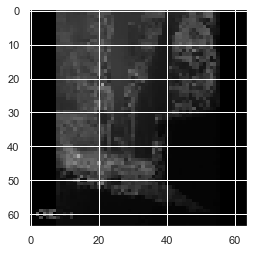

In [265]:
plt.imshow(res1)

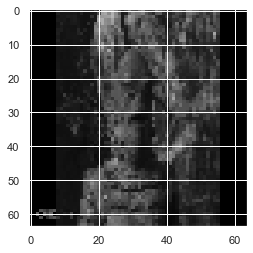

In [266]:
plt.imshow(res2)

In [267]:
pixel_metric(res1,res2)

1461.339111328125

In [ ]:
385.052734375

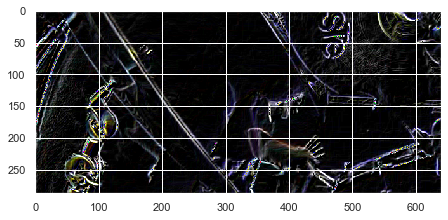

In [16]:
prevo = vis_base[1][0]
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(get_border(prevo)[:,:,::-1])


False


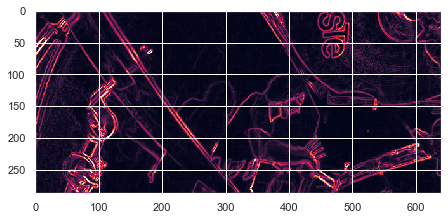

In [162]:
#первая попытка свернуть в собель
scale = 1
delta = 0
ddepth = cv2.CV_16S


prevo2 = vis_base[1][0]

gray = cv2.cvtColor(prevo2, cv2.COLOR_BGR2GRAY)

grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
     
abs_grad_x = cv2.convertScaleAbs(grad_x)
abs_grad_y = cv2.convertScaleAbs(grad_y)
    
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(SobelBorder(prevo2))
print(IsImageGray(prevo2))

6829.714415926415
18.672507618209462


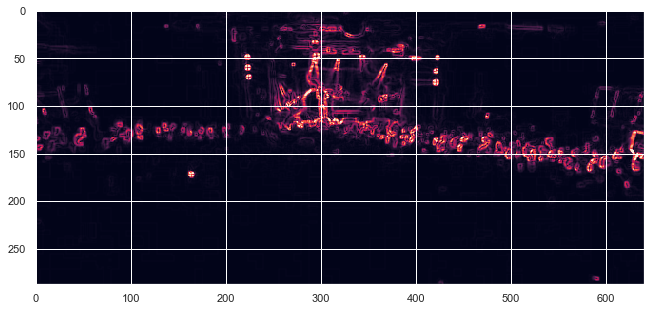

In [18]:
#Sobel свертка
idx = 6

prevol = vis_base[idx][0]
prevol2 = vis_base[idx][1]

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(SobelBorder(prevol))


def pixel_metric3(frame, prev_frame):
    return (np.mean(frame.astype(np.int32) - prev_frame) ** 2)
    
    
print(pixel_metric3(prevol, prevol2))
print(pixel_metric3(SobelBorder(prevol), SobelBorder(prevol2)))

779.625

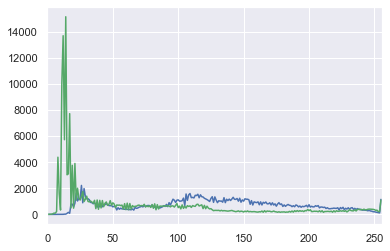

In [25]:
#разбираюсь с гистограммами
idx = 1

img1 = vis_base[idx][0]
img2 = vis_base[idx][1]

#yuv1 = cv2.cvtColor(prevo2, cv2.COLOR_BGR2YUV)
#yuv2 = cv2.cvtColor(img1, cv2.COLOR_BGR2YUV)

# gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
# gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

diff = 0

histr = cv2.calcHist([img1],[diff],None,[256],[0,256])
histr2 = cv2.calcHist([img2],[diff],None,[256],[0,256])

plt.plot(histr,color = 'b')
plt.xlim([0,256])
plt.plot(histr2,color = 'g')
plt.xlim([0,256])
# plt.plot(np.abs(histr-histr2),color = 'r')
# plt.xlim([0,256])

def IsImageGray(im_to_check, border):
    yuv = cv2.cvtColor(im_to_check, cv2.COLOR_BGR2YUV)
    histr = cv2.calcHist([yuv],[0],None,[256],[0,256])
    res = np.max(histr) > border
    return res

Hist_Differ(img1, img2)

In [263]:
idx = 1

img1 = vis_base[idx][0]
img2 = vis_base[idx][1]

Hist_Differ(img1, img2)

36534.0

287.35938
1030.9919875370751


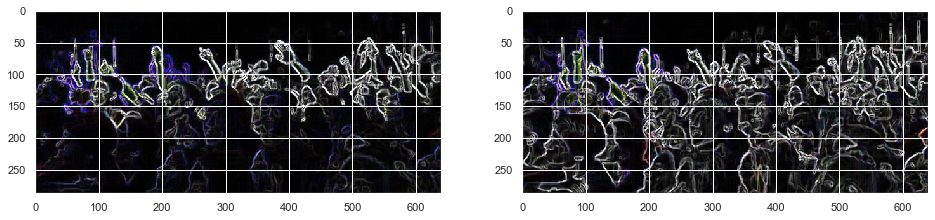

In [910]:
#Разработка четвертой метрики pixel и второго сравнения гистограмм

idx = 40

img1 = vis[idx][0]
img2 = vis[idx][1]


def Hist_Differ2(img1, img2):
    histr = cv2.calcHist([img1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([img2],[0],None,[256],[0,256])
    return np.mean(np.abs(histr-histr2))

my_hist = cv2.calcHist([img1],[0],None,[256],[0,256])

p1 = SobelBorder(img1) 
p2 = SobelBorder(img2) 

def move(image, kul):
    zer = np.zeros((image.shape[0], kul)) 
    hu = np.column_stack((image, zer))
    ar = hu[:,kul:]
    return ar

p2 = i


def pixel_metric4(frame, prev_frame):
    return (np.mean(frame.astype(np.int32) - prev_frame) ** 2)

p1 = SobelBorder3(img1)
p2 = SobelBorder3(img2)

plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
ax.imshow(p1)
ax = plt.subplot(222)
ax.imshow(p2)
mine_err = 1000
for i in range(30):
    for k in range(30):   
        z1 =  p1[i - 15 + 64:-64 + i - 15,k - 15 +64:-64 + k - 15]
        z2 =  p2[64:-64,64:-64]
        if (pixel_metric4(z1,z2) < mine_err):
            mine_err = pixel_metric4(z1,z2)
            
print(Hist_Differ2(p1,p2))
print(pixel_metric4(img1,img2))
#print(Hist_Differ2(SobelBorder(img1),SobelBorder(img2)))

okkk


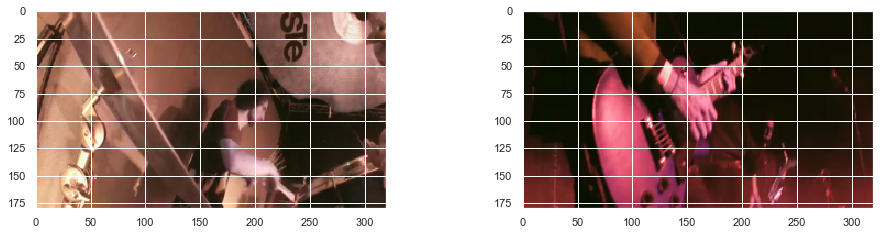

In [1524]:
#попытка разработки метрики ME 2

num = 1

img1 = vis[num][0]
img2 = vis[num][1]


img1_res = cv2.resize(img1, dsize=(init_size_x // multi, init_size_y // multi))
img2_res = cv2.resize(img2, dsize=(init_size_x // multi, init_size_y // multi))

plt.figure(figsize=(16, 8))
ax = plt.subplot(221)
ax.imshow(img1_res)
ax = plt.subplot(222)
ax.imshow(img2_res)

sum_err = MetricME(img1,img2)

#### Обратите внимание на скорость работы алгоритма! ####
Если вычислять признаки без циклов по пикселям, а пользоваться методами из numpy, то скорость будет не медленнее 7-8 кадров в секунду.
Например, вы можете использовать функцию `np.histogram` или `cv2.calcHist` для подсчёта гистограмм, а `cv2.Sobel` для применения оператора Собеля к кадру.

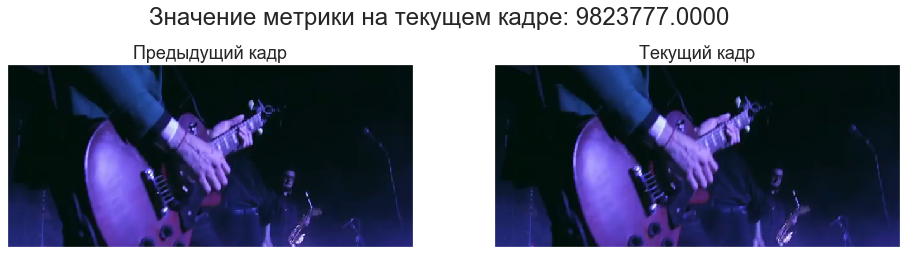

In [1482]:
#Посмотрим на найденные смены сцен
idx = 
visualize_metric_error(vis[idx][0], vis[idx][1], metric_values[scene_changes[idx]])

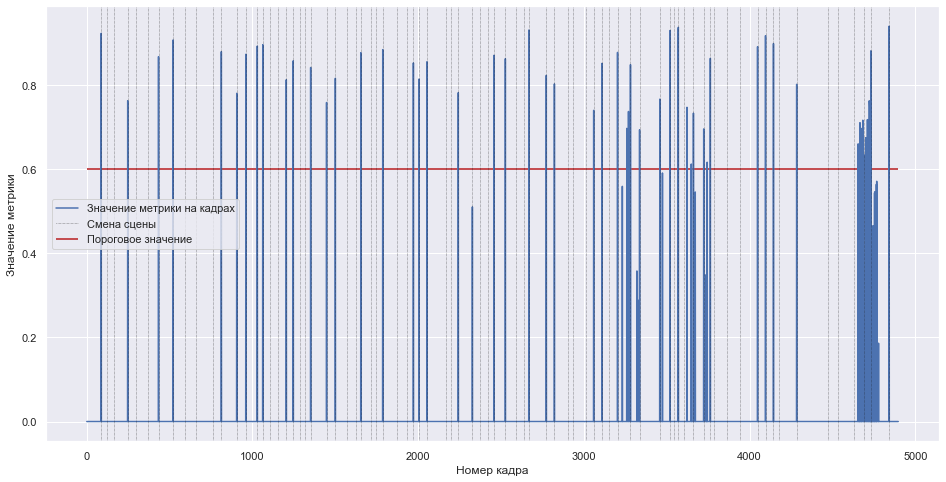

In [124]:
#Посмотрим на значения метрики
visualize_metric_values(metric_values, 0.6, cuts)

### Подсчёт метрики F1-Score

Чтобы оценивать алгоритм и научиться сравнивать несколько алгоритмов, нужна метрика качества. В данной задаче для оценки качества алгоритма используется F1-Score. Преимущества использования этой метрики к текущей постановке задачи смены сцен были рассказаны на лекции, напишем только формулы:
$$precision = \frac{tp}{tp+fp}$$
$$recall = \frac{tp}{tp+fn}$$
$$F = 2 * \frac{precision * recall}{precision+recall}$$

На всякий случай опишем как именно происходит подсчёт метрики для видео

1) Сначала из выборки удаляются все кадры, которые по разметке либо являются сложными переходами между сценами, либо помечены как сложные для анализа и разметки (например, титры/обилие компьютерной графики и т.п)


2) Затем для оставшихся кадров уже подсчитывается F1_Score

In [482]:
#Эти пять клеток кода править не нужно
def calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    for scd in predicted_scd:
        if scd in true_scd:
            tp += 1
        elif scd not in not_to_use_frames:
            fp += 1
    for scd in true_scd:
        if scd not in predicted_scd:
            fn += 1
    tn = scene_len - len(not_to_use_frames) - tp - fp - fn
    return tp, fp, tn, fn

In [483]:
def calculate_precision(tp, fp, tn, fn):
    return tp / max(1, (tp + fp))

In [484]:
def calculate_recall(tp, fp, tn, fn):
    return tp / max(1, (tp + fn))

In [485]:
def f1_score(true_scd, predicted_scd, scene_len, not_to_use_frames=set()):
    tp, fp, tn, fn = calculate_matrix(true_scd, predicted_scd, scene_len, not_to_use_frames)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [486]:
def f1_score_matrix(tp, fp, tn, fn):
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

### Тестируем разработанный метод сразу на нескольких видео 

Проверим, насколько хорошо работает разработанный метод. *Учтите, что итоговое тестирование будет производиться на аналогичном, но недоступном вам наборе видео, но все параметры алгоритмов должны быть указаны вами (иными словами - подобраны на тренировочном наборе).*

In [30]:
def run_scene_change_detector_all_video(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        # Загружаем видео, его длину и смены сцен
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))
        
        # Составляем список сцен, которые не будут тестироваться
        not_use_frames = set()
        for type_scene_change in ['trash', 'fade', 'dissolve']:
            for bad_scene_range in true_scene_changes.get(type_scene_change, []):
                not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))
        
        predicted_scene_changes, _, _ = scene_change_detector(frames)
        
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix(
            true_scene_changes['cut'],
            predicted_scene_changes,
            video_len,
            not_use_frames
        )
        
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn 
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [26]:
video_dataset = 'train_dataset'

Данная функция поможет вам посмотреть, на каких видео и на сколько ошибается ваш метод. Прогнать метод на отдельном видео и детально посмотреть кадры вы могли выше.

Кроме того, с помощью этой функции вы можете подобрать оптимальные параметры для метода.

In [117]:
#Протестируем базовый метод
run_scene_change_detector_all_video(baseline_scene_change_detector, video_dataset)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


KeyboardInterrupt: 

In [214]:
#Протестируем разработанный вамиметод
run_scene_change_detector_all_video(scene_change_detector, video_dataset)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


{'_mean_f1_score': 0.8259155755290012,
 'f1_score_video/03.mp4': 0.8363636363636363,
 'tp_video/03.mp4': 23,
 'fp_video/03.mp4': 9,
 'tn_video/03.mp4': 3163,
 'fn_video/03.mp4': 0,
 'f1_score_video/04.mp4': 0.9836065573770492,
 'tp_video/04.mp4': 30,
 'fp_video/04.mp4': 1,
 'tn_video/04.mp4': 3357,
 'fn_video/04.mp4': 0,
 'f1_score_video/05.mp4': 0.972972972972973,
 'tp_video/05.mp4': 18,
 'fp_video/05.mp4': 1,
 'tn_video/05.mp4': 5255,
 'fn_video/05.mp4': 0,
 'f1_score_video/07.mp4': 0.8888888888888888,
 'tp_video/07.mp4': 100,
 'fp_video/07.mp4': 23,
 'tn_video/07.mp4': 3196,
 'fn_video/07.mp4': 2,
 'f1_score_video/08.mp4': 0.9047619047619047,
 'tp_video/08.mp4': 19,
 'fp_video/08.mp4': 0,
 'tn_video/08.mp4': 2587,
 'fn_video/08.mp4': 4,
 'f1_score_video/10.mp4': 0.7692307692307692,
 'tp_video/10.mp4': 40,
 'fp_video/10.mp4': 22,
 'tn_video/10.mp4': 2676,
 'fn_video/10.mp4': 2,
 'f1_score_video/14.mp4': 0.7843137254901961,
 'tp_video/14.mp4': 40,
 'fp_video/14.mp4': 22,
 'tn_video/14

Когда вы смотрите на результат, обращайте внимание на **_mean_f1_score**  
Именно по этой метрике будет производится финальное оценивание.

## Бонусное задание: распознавание смен сцен типа "наложения"

На практике кроме катов часто встречаются смены сцен, где происходит "наложение" одной сцены на другую:

<img src="Dissolve.jpg">

### Ваше решение 

* В качестве решения вы должны прикрепить функцию ниже. Все пороги должны быть указаны внутри функции.  
Т.е. должен быть возможен вызов:  
`scene_changes, vis, metric_values = scene_change_detector_dissolve(frames)`  
* Строку (# GRADED FUNCTION: [function name]) менять **нельзя**. Она будет использоваться при проверке вашего решения.
* Ячейка должна содержать только **одну** функцию.

In [208]:
# GRADED FUNCTION: scene_change_detector_dissolve

#по идее у нас до какого-то момента во время dissolve растет метрика, а затем должна падать

def scene_change_detector_dissolve(frames, threshold=None, with_vis=False):
    scene_changes = []
    vis = []
    metric_values = []
    fill = 0
    prev_frames = []
    kol = 21
    prev_frame = None
    for idx, frame in tqdm(enumerate(frames), leave=False):
        if (fill > kol):
            metric_value = pixel_metric7(frame, prev_frame)
            
            metric_values.append(metric_value)
            
            prev_frames.pop(0)
            prev_frames.append(frame)
            #now we want to analyze our sequence
            count = 0
            for i in range(kol // 2):
                if (metric_values[idx - kol + i] < metric_values[idx - kol + i + 1]):
                    count += 1
            for i in range(kol // 2 - 1):
                if (metric_values[idx - (kol//2) + i] > metric_values[idx - (kol//2) + i + 1]):
                    count += 1
            
            if (count > kol//2):
                scene_changes.append(idx - kol//2 - 1)
                if with_vis:
                    if len(vis) < 100:
                        vis.append([prev_frame, frame])
                        
            prev_frame = frame
        else:
            metric_values.append(0)
            prev_frames.append(frame)
            fill += 1
            prev_frame = frame
        pass

    return scene_changes, vis, metric_values

В качестве метрики качества используется видоизменённый f1-score:

Так как смена сцен не происходит за один кадр, попаданием считается попадание ответа смены сцен в отрезок, где происходит наложение.  
**Обратите внимание**, что несколько раз указывать одну смену сцен не нужно.

Попадание вне отрезков смен сцен путём наложения считается как false positive, не попадание в указанный отрезок - как false negative

In [204]:
#Эти три клетки кода править не нужно
def calculate_matrix_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = 0, 0, 0, 0
    scene_len = scene_len
    checked_dissolve_segments = set()
    total_scene_dissolve_len = np.sum([dissolve_segment[1] - dissolve_segment[0] + 1 for dissolve_segment in true_scd])
    for scd in predicted_scd:
        for dissolve_segment in true_scd:
            if scd in range(dissolve_segment[0], dissolve_segment[1] + 1):
                tp += 1
                checked_dissolve_segments.add(tuple(dissolve_segment))
                break
        else:
            fp += 1
    fn = len(true_scd) - len(checked_dissolve_segments)
    tn = scene_len - total_scene_dissolve_len + len(true_scd) - tp - fp - fn
    return tp, fp, tn, fn

In [205]:
def f1_score_dissolve(true_scd, predicted_scd, scene_len):
    tp, fp, tn, fn = calculate_matrix_dissolve(true_scd, predicted_scd, scene_len)
    precision_score = calculate_precision(tp, fp, tn, fn)
    recall_score = calculate_recall(tp, fp, tn, fn)
    if precision_score + recall_score == 0:
        return 0
    else:
        return 2 * precision_score * recall_score / (precision_score + recall_score)

In [206]:
def run_scene_change_detector_all_video_dissolve(scene_change_detector, dataset_path):
    video_dataset = load_json_from_file(os.path.join(dataset_path, 'info.json'))
    param_log = {
        '_mean_f1_score': []
    }
    for video_info in tqdm(video_dataset, leave=False):
        frames = read_video(os.path.join(dataset_path, video_info['source']))
        video_len = video_info['len']
        true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))
        
        predicted_scene_changes, _, _ = scene_change_detector(frames)
        param_log['f1_score_{}'.format(video_info['source'])] = f1_score_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        video_tp, video_fp, video_tn, video_fn = calculate_matrix_dissolve(
            true_scene_changes.get('dissolve', []),
            predicted_scene_changes,
            video_len
        )
        param_log['tp_{}'.format(video_info['source'])] = video_tp
        param_log['fp_{}'.format(video_info['source'])] = video_fp
        param_log['tn_{}'.format(video_info['source'])] = video_tn
        param_log['fn_{}'.format(video_info['source'])] = video_fn
        param_log['_mean_f1_score'].append(param_log['f1_score_{}'.format(video_info['source'])])
    param_log['_mean_f1_score'] = np.mean(param_log['_mean_f1_score'])
    return param_log

In [201]:
video_dataset_path = 'train_dataset'

In [215]:
#Протестируем разработанный вами метод
run_scene_change_detector_all_video_dissolve(scene_change_detector_dissolve, video_dataset_path)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


{'_mean_f1_score': 0.015024342801270418,
 'f1_score_video/03.mp4': 0.0366361365528726,
 'tp_video/03.mp4': 22,
 'fp_video/03.mp4': 1155,
 'tn_video/03.mp4': 2024,
 'fn_video/03.mp4': 2,
 'f1_score_video/04.mp4': 0.00245398773006135,
 'tp_video/04.mp4': 1,
 'fp_video/04.mp4': 813,
 'tn_video/04.mp4': 2575,
 'fn_video/04.mp4': 0,
 'f1_score_video/05.mp4': 0.05123825789923143,
 'tp_video/05.mp4': 30,
 'fp_video/05.mp4': 1111,
 'tn_video/05.mp4': 4412,
 'fn_video/05.mp4': 0,
 'f1_score_video/07.mp4': 0,
 'tp_video/07.mp4': 0,
 'fp_video/07.mp4': 919,
 'tn_video/07.mp4': 2402.0,
 'fn_video/07.mp4': 0,
 'f1_score_video/08.mp4': 0.028169014084507043,
 'tp_video/08.mp4': 16,
 'fp_video/08.mp4': 1104,
 'tn_video/08.mp4': 2217,
 'fn_video/08.mp4': 0,
 'f1_score_video/10.mp4': 0,
 'tp_video/10.mp4': 0,
 'fp_video/10.mp4': 1895,
 'tn_video/10.mp4': 4201.0,
 'fn_video/10.mp4': 0,
 'f1_score_video/14.mp4': 0.031746031746031744,
 'tp_video/14.mp4': 8,
 'fp_video/14.mp4': 487,
 'tn_video/14.mp4': 1793

### Немного об оценивании задания

Оценивание задания будет производиться по следующей схеме:  

Пусть на скрытой выборке по F-метрике вы получили X, лучшее решение получило Y.

1. Базовая часть оценивется как $$20 * \left(\frac{\max(0, X_{base} - 0.5)}{Y_{base} - 0.5}\right)^2 + Bonus_{base}$$ Бонусные баллы $Bonus$ можно получить за оригинальные идеи в задаче или в её реализации
2. Дополнительное задание оценивается как $$5 * \frac{\max(0, X_{add} - 0.1)}{Y_{add} - 0.1} + Bonus_{add}$$Процесс получения бонусных баллов аналогичен получению бонусных баллов в базовой части

### Ваши ощущения ##

*До дедлайна пару часов и вы никак не можете улучшить текущее решение? Или наоборот, вы всё сделали очень быстро? Опишите кратко ваши ощущения от задания - сколько времени вы потратили на задание, сколько вы потратили на изучение питона и установку необходимых библиотек, как быстро вы придумывали новые идеи и как они давали прирост по метрике и в целом насколько это задание вам понравилось и что хотели бы изменить/добавить.*

# Немного о разработке

Не получается придумать метрику не зависимую от яркости

0) Неплохие результаты для линейной комбинации метрики анализа разницы по модулю гистограмм и обычной MSE
(0.77)

1) Кажется все-таки для черно белого изображения все не так просто - лучше его различать и прогонять отдельно, может хеш функцией? Получилось, 0.9 на черно-белом, портят только цветные сцены в конце. 

2) Пробую имплементировать более совершенную меттрику( SSIM). Наконец 21 видео подчинилось

3) Адаптивные технологии точек фокуса на изображении (не успею?) 2001 год?

4) много метрик, но дым на 21 видео не берет ничего кроме SSIM. Нужна метрика не зависящая от яркости (особый анализ гистограмм?)

5) хочу нормализовать гистограммы, раз нам разрешили с ними работать

6) Почему так странно на аниме? Кажется SSIM не идеален. Яркие сцены пролета зато отлично берет Hist_Differ. Примитивно их скомбинировал

7) Фильтры собеля очень полезны, кажется можно именно по ним делать SSIM 

8) может мне делать ресайз для SSIM? Тогда будет запас для других метрик вроде Hist_Differ

9) MetricME - метрика с движением кусков и минимизацией ошибки показала себя не очень эффективной. Может нужно ее использовать вместе с Собелем?

10) Почему NewMetric про которую я забыл может страховать SSIM? Честно не знаю

11) TODO: Переименовать бесконечные метрики

12) Resize перед SSIM оказался точно быстрее, но вопрос другой - вытянет ли он теперь сложные сцены в 21 видео?

13) 21 видео все портит, рекорд метрики 0.83, 2 часа до дедлайна

14) не получается исправить проблему с видео 21, ssim плохо различает клубы дыма в конце. 1:20 до дедлана

15) Пока считается метрика пытаюсь реализовать идею с Dissolve

16) Ничего реализовать не получилось, последний раз запускаю прогон по метрике, dissolve кажется не удался. а еще я только сейчас понял в чем проблема того что я хотел в dissolve сделал. 40 минут до дедлайна, метрика всего лишь 0.83 и не факт что удержится на реальных данных

17) забыл какие параметры менял, 0.81, полчаса до дедлайна. Срочно нужно вернуть все как было

18) Вернул примерно 0.83. Время сдавать. На всякий случай запущу dissolve 

19) Dissolve конечно надо было доделать, очень так себе. Параметры я совсем не успеваю подобрать. Сдаю, 6 минут до дедлайна, пока задание кажется классным

<a id='second'></a>

## Задание 2. Scene change detector. Машинное обучение

**Внимание!**

В этом задании можно использовать все, что разрешалось в Задании №1, а также библиотеки:
* pandas
* sklearn

Большинство функций, использующихся в этом задании, реализованы выше.

### Бейзлайн

In [5]:
from sklearn.svm import SVC
import pickle5 as pickle
import pandas as pd


Обучим простой SVM классификатор над метрикой попиксельной разницы кадров на нескольких видео. Воспользуемся функцией из первого задания

In [6]:
def get_train_data(train_videos):
    X_train, y_train = np.array([]), np.array([])
    for video in train_videos:
        frames = read_video(os.path.join('train_dataset', 'video', f'{video}.mp4'))
        # baseline функция попиксельного сравнения кадров из прошлого задания
        # нам нужны не сами смены сцен, а только значения метрик
        _, _, metric_values = baseline_scene_change_detector(frames) 
        
        cuts = load_json_from_file(os.path.join('train_dataset', 'gt', f'{video}.json'))['cut']
        video_scenes = np.array([0 for i in range(len(metric_values))])
        video_scenes[cuts] += 1
        
        # добавляем в разметку текущее видео
        X_train = np.hstack((X_train, metric_values))
        y_train = np.hstack((y_train, video_scenes))
        
    return X_train, y_train 

In [490]:
train_videos = ['04', '05']

X_train, y_train = get_train_data(train_videos)

NameError: name 'baseline_scene_change_detector' is not defined

In [15]:
# создание модели
# подберите лучшие параметры для данной задачи
params = {"kernel": "rbf", "C": 1,
         d
         
         }
model = SVC(**params)
model.fit(X_train.reshape(-1, 1), y_train)

SVC(C=1)

 Сохраним модель в файле *model.pkl*

In [16]:
pickle.dump(model, open("model.pkl", "wb"))

Посмотрим как модель работает на тестовых видео

Обратите внимание на то, что внутри функции модель загружается из памяти из файла *model.pkl*

In [17]:
def baseline_scene_change_detection_ml(frames):
    # подготавливаем данные для видео
    _, _, metric_values = baseline_scene_change_detector(frames) 
    X_test = np.array(metric_values).reshape(-1, 1)
    
    # загружаем модель и делаем предсказания
    model = pickle.load(open("model.pkl", 'rb')) 
    predict_cuts = model.predict(X_test)
    
    return np.where(predict_cuts > 0)[0]

In [467]:
def run_scene_change_detector_ml_one_video(scene_change_detector, dataset_path, video_num):
    video_info = load_json_from_file(os.path.join(dataset_path, 'info.json'))[video_num]
    
    # Загружаем видео, его длину и смены сцен
    frames = read_video(os.path.join(dataset_path, video_info['source']))
    video_len = video_info['len']
    true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

    # Составляем список сцен, которые не будут тестироваться
    not_use_frames = set()
    for type_scene_change in ['trash', 'fade', 'dissolve']:
        for bad_scene_range in true_scene_changes.get(type_scene_change, []):
            not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))

    predicted_scene_changes = scene_change_detector(frames)

    return  f1_score(
        true_scene_changes['cut'],
        predicted_scene_changes,
        video_len,
        not_use_frames
    )
        

In [505]:
dataset_path

NameError: name 'dataset_path' is not defined

Посчитаем F1 score для одного видео:

In [25]:
video_num = 3
run_scene_change_detector_ml_one_video(baseline_scene_change_detection_ml, 'train_dataset', video_num)

0.8317757009345794

### Ваше решение

Чтобы использовать свою обученную модель при отправке решения, необходимо сохранить ее через пакет pickle в файл model.pkl и отправить его вместе с jupyter ноутбуком.
Этот файл вы можете открывать и использовать прямо в функции вашего решения

* В качестве решения вы должны прикрепить функцию ниже. Все пороги должны быть указаны внутри функции.  
Т.е. должен быть возможен вызов:  
`scene_changes, vis, metric_values = scene_change_detector_dissolve(frames)`  
* Строку (# GRADED FUNCTION: [function name]) менять **нельзя**. Она будет использоваться при проверке вашего решения.
* Ячейка должна содержать только **одну** функцию.

In [487]:
def get_border(framo):
    sobel = cv2.Sobel(framo,0,0,1)
    sobel2 = cv2.Sobel(framo,0,1,0)
    prevo3 = sobel+sobel2
    return prevo3


def Hist_Differ(img1, img2):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    histr = cv2.calcHist([gray1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([gray2],[0],None,[256],[0,256])
    #must use mean
    return np.mean(np.abs(histr-histr2))

def NewMetric(img1, img2):
    def SobelBorder3(img):
        ddepth = cv2.CV_16S
        scale = 1
        delta = 0
        gray = img
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        return grad
    
    ig1 = SobelBorder3(img1)
    ig2 = SobelBorder3(img2)
    histr = cv2.calcHist([ig1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([ig2],[0],None,[256],[0,256])
    return np.mean(np.abs(histr-histr2))

def pixel_metric3(frame, prev_frame):
    return (np.mean(SobelBorder(frame).astype(np.int32) - SobelBorder(prev_frame)) ** 2) *40

#!!!!
def pixel_metric7(frame, prev_frame):
    im1 = cv2.resize(frame, (200,200))
    im2 = cv2.resize(prev_frame, (200,200))
    return (1 - ssim_metric(im1,im2))
#!!!!

def pixel_metric8(frame, prev_frame):
    im1 = cv2.resize(frame, (128,128))
    im2 = cv2.resize(prev_frame, (128,128))
    img_1 = SobelBorder(im1)
    img_2 = SobelBorder(im2)
    return (1 - ssim_metric(img_1,img_2))




def pixel_metric6(frame, prev_frame):
    res1 = cv2.resize(frame, (200,200),cv2.INTER_NEAREST)
    res2 = cv2.resize(prev_frame, (200,200),cv2.INTER_NEAREST)
    return (np.mean(SobelBorder(res1).astype(np.int32) - SobelBorder(res2)) ** 2) *40

def pixel_metric2(frame, prev_frame):
    return Hist_Differ(frame,prev_frame)

def IsImageGray(img):
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            if not(img[x,y][0] == img[x,y][1] == img[x,y][2]):
                return False

    return True   

def New_Hist_Differ(img1, img2):
    h1 = SobelBorder(img1)
    h2 = SobelBorder(img2)
    histr = cv2.calcHist([h1],[0],None,[256],[0,256])
    histr2 = cv2.calcHist([h2],[0],None,[256],[0,256])
    return cv2.compareHist(histr, histr2, 2)

def pixel_metric(frame, prev_frame):
    # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
    return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

def pixel_metric4(frame, prev_frame):
    init_size_x = 1280
    init_size_y = 720
    multi = 2
    img1_res = cv2.resize(frame, dsize=(init_size_x // multi, init_size_y // multi))
    img2_res = cv2.resize(prev_frame, dsize=(init_size_x // multi, init_size_y // multi))
    sum_err = 0
    def Error(pr1,pr2):
        return (np.mean(pr1 - pr2) ** 2);
    b_s = 40
    for i in range (init_size_x//b_s- 2) :
        for k in range (init_size_y//b_s- 2) :
            test_1 = img1_res[b_s + i*b_s:b_s + (i+1)*(b_s),b_s +k*b_s:b_s +(k+1)*(b_s)]
            new_error = 100000000
            for z1 in range(3):
                for z2 in range(3):
                    test_2 = img2_res[i*b_s + z1 + b_s:(i+1)*(b_s)+ z1 + b_s,b_s +k*b_s+ z2:b_s +(k+1)*(b_s)+ z2]
                    if (Error(test_1,test_2) < new_error):
                        new_error = Error(test_1,test_2)
            sum_err += new_error
    return sum_err


def pixel_metric5(frame, prev_frame):
    res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
    res2 = cv2.resize(prev_frame, (64,64),cv2.INTER_NEAREST)
    return pixel_metric(res1,res2)

def pixel_metric5_prev(frame, prev_frame):
    res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
    return pixel_metric(res1,prev_frame)

def median(image):
    return cv2.medianBlur(image, 5)


def median_pixel_metric(frame, prev_frame):
    return pixel_metric2(median(frame),median(prev_frame))

def upd_metric(fr1, fr2):
    res1 = cv2.resize(fr1, (64,64))
    res2 = cv2.resize(fr2, (64,64))
    return median_pixel_metric(fr1,fr2)

def hist_metric_2_0(img1,img2):
    hist = cv2.calcHist([img1],[0],None,[256],[0,256])
    hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])
    return cv2.compareHist(hist, hist2,cv2.HISTCMP_BHATTACHARYYA )

from skimage.metrics import structural_similarity as ssim

def ssim_metric(img1,img2):
    return ssim(img1, img2, multichannel=True)

def SobelBorder(img):
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

def SobelBorder2(img):
    ddepth = cv2.CV_16S
    scale = 1
    delta = 0
    gray = img
    grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

def MetricME(im_my1, im_my2):
    init_size_x = 1280
    init_size_y = 720
    multi = 8
    img1_res = cv2.resize(im_my1, dsize=(init_size_x // multi, init_size_y // multi))
    img2_res = cv2.resize(im_my2, dsize=(init_size_x // multi, init_size_y // multi))
    sum_err = 0
    def Error(pr1,pr2):
        return abs(np.sum(pr1 - pr2))

    for i in range (5):
        for k in range (9):
            test_1 = img1_res[i:i+16,k:k+10]
            new_error = 1000000
            for z1 in range(4):
                for z2 in range(4):
                    test_2 = img2_res[min(0,z1 - 32):min(0,z1 - 32)+32,min(0,z2 - 20):min(0,z2 - 20)+10]
                    if (Error(test_1,test_2) < new_error):
                        new_error = Error(test_1,test_2)
            sum_err += new_error
    return sum_err

def denoise(image):
    ret = denoise_wavelet(image, rescale_sigma=True)
    return ret



import skimage

def blur2(image):
    ret = skimage.filters.gaussian(image, sigma=(3, 3), truncate=3.5, multichannel=True)
    return ret

def gray_sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_sobelh = sobel_h(gray)
    return image_sobelh

def gr_ssim(imagel,image2l):
    iml1 = cv2.resize(imagel, (200,200)) 
    iml2 = cv2.resize(image2l, (200,200))
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 5),       sharex=True, sharey=True)
    ax[0,0].imshow(gray_sobel(iml1))
    ax[0,1].imshow(gray_sobel(iml2))
    return 1 - ssim_metric(denoise(gray_sobel(iml1)),denoise(gray_sobel(iml2)))
    
def blur_ssim(image,image2):
    return pixel_metric7(blur2(image),blur2(image2))

def Insert_row(row_number, df, row_value):

    # Начальное значение верхней половины
    start_upper = 0
    # Конечное значение верхней половины
    end_upper = row_number
    # Начальное значение нижней половины
    start_lower = row_number
    # Конечное значение нижней половины
    end_lower = df.shape[0]
    # Создать список индекса upper_half
    upper_half = [*range(start_upper, end_upper, 1)]
    # Создать список индекса lower_half
    lower_half = [*range(start_lower, end_lower, 1)]
    # Увеличить значение нижней половины на 1
    lower_half = [x.__add__(1) for x in lower_half]
    # Объединить два списка
    index_ = upper_half + lower_half
    # Обновить индекс данных
    df.index = index_
    # Вставить строку в конце
    df.loc[row_number] = row_value
    # Сотировать метки индекса

    df = df.sort_index()
    # вернуть фрейм данных

    return df

In [537]:
# GRADED FUNCTION: scene_change_detector_ml

import skimage
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise
from skimage import filters
from skimage.filters import sobel_h
from sklearn.preprocessing import StandardScaler

def scene_change_detector_ml(frames, with_vis = False):
    scene_changes = []
    vis = []
    metric_values = []
   
    def Insert_row(row_number, df, row_value):

        # Начальное значение верхней половины
        start_upper = 0
        # Конечное значение верхней половины
        end_upper = row_number
        # Начальное значение нижней половины
        start_lower = row_number
        # Конечное значение нижней половины
        end_lower = df.shape[0]
        # Создать список индекса upper_half
        upper_half = [*range(start_upper, end_upper, 1)]
        # Создать список индекса lower_half
        lower_half = [*range(start_lower, end_lower, 1)]
        # Увеличить значение нижней половины на 1
        lower_half = [x.__add__(1) for x in lower_half]
        # Объединить два списка
        index_ = upper_half + lower_half
        # Обновить индекс данных
        df.index = index_
        # Вставить строку в конце
        df.loc[row_number] = row_value
        # Сотировать метки индекса

        df = df.sort_index()
        # вернуть фрейм данных

        return df
    
    
    def get_border(framo):
        sobel = cv2.Sobel(framo,0,0,1)
        sobel2 = cv2.Sobel(framo,0,1,0)
        prevo3 = sobel+sobel2
        return prevo3


    def Hist_Differ(img1, img2):
        gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        histr = cv2.calcHist([gray1],[0],None,[256],[0,256])
        histr2 = cv2.calcHist([gray2],[0],None,[256],[0,256])
        #must use mean
        return np.mean(np.abs(histr-histr2))

    def NewMetric(img1, img2):
        def SobelBorder3(img):
            ddepth = cv2.CV_16S
            scale = 1
            delta = 0
            gray = img
            grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
            grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
            abs_grad_x = cv2.convertScaleAbs(grad_x)
            abs_grad_y = cv2.convertScaleAbs(grad_y)
            grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
            return grad

        ig1 = SobelBorder3(img1)
        ig2 = SobelBorder3(img2)
        histr = cv2.calcHist([ig1],[0],None,[256],[0,256])
        histr2 = cv2.calcHist([ig2],[0],None,[256],[0,256])
        return np.mean(np.abs(histr-histr2))

    def pixel_metric3(frame, prev_frame):
        return (np.mean(SobelBorder(frame).astype(np.int32) - SobelBorder(prev_frame)) ** 2) *40

    #!!!!
    def pixel_metric7(frame, prev_frame):
        im1 = cv2.resize(frame, (170,170))
        im2 = cv2.resize(prev_frame, (170,170))
        return (1 - ssim_metric(im1,im2))
    #!!!!

    def pixel_metric8(frame, prev_frame):
        im1 = cv2.resize(frame, (128,128))
        im2 = cv2.resize(prev_frame, (128,128))
        img_1 = SobelBorder(im1)
        img_2 = SobelBorder(im2)
        return (1 - ssim_metric(img_1,img_2))




    def pixel_metric6(frame, prev_frame):
        res1 = cv2.resize(frame, (200,200),cv2.INTER_NEAREST)
        res2 = cv2.resize(prev_frame, (200,200),cv2.INTER_NEAREST)
        return (np.mean(SobelBorder(res1).astype(np.int32) - SobelBorder(res2)) ** 2) *40

    def pixel_metric2(frame, prev_frame):
        return Hist_Differ(frame,prev_frame)

    def IsImageGray(img):
        for x in range(img.shape[0]):
            for y in range(img.shape[1]):
                if not(img[x,y][0] == img[x,y][1] == img[x,y][2]):
                    return False

        return True   

    def New_Hist_Differ(img1, img2):
        h1 = SobelBorder(img1)
        h2 = SobelBorder(img2)
        histr = cv2.calcHist([h1],[0],None,[256],[0,256])
        histr2 = cv2.calcHist([h2],[0],None,[256],[0,256])
        return cv2.compareHist(histr, histr2, 2)

    def pixel_metric(frame, prev_frame):
        # Базовое расстояние между кадрами - среднеквадратическая ошибка между ними
        return np.mean((frame.astype(np.int32) - prev_frame) ** 2)

    def pixel_metric4(frame, prev_frame):
        init_size_x = 1280
        init_size_y = 720
        multi = 2
        img1_res = cv2.resize(frame, dsize=(init_size_x // multi, init_size_y // multi))
        img2_res = cv2.resize(prev_frame, dsize=(init_size_x // multi, init_size_y // multi))
        sum_err = 0
        def Error(pr1,pr2):
            return (np.mean(pr1 - pr2) ** 2);
        b_s = 40
        for i in range (init_size_x//b_s- 2) :
            for k in range (init_size_y//b_s- 2) :
                test_1 = img1_res[b_s + i*b_s:b_s + (i+1)*(b_s),b_s +k*b_s:b_s +(k+1)*(b_s)]
                new_error = 100000000
                for z1 in range(3):
                    for z2 in range(3):
                        test_2 = img2_res[i*b_s + z1 + b_s:(i+1)*(b_s)+ z1 + b_s,b_s +k*b_s+ z2:b_s +(k+1)*(b_s)+ z2]
                        if (Error(test_1,test_2) < new_error):
                            new_error = Error(test_1,test_2)
                sum_err += new_error
        return sum_err


    def pixel_metric5(frame, prev_frame):
        res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
        res2 = cv2.resize(prev_frame, (64,64),cv2.INTER_NEAREST)
        return pixel_metric(res1,res2)

    def pixel_metric5_prev(frame, prev_frame):
        res1 = cv2.resize(frame, (64,64),cv2.INTER_NEAREST)
        return pixel_metric(res1,prev_frame)

    def median(image):
        return cv2.medianBlur(image, 5)


    def median_pixel_metric(frame, prev_frame):
        return pixel_metric2(median(frame),median(prev_frame))

    def upd_metric(fr1, fr2):
        res1 = cv2.resize(fr1, (64,64))
        res2 = cv2.resize(fr2, (64,64))
        return median_pixel_metric(fr1,fr2)

    def hist_metric_2_0(img1,img2):
        hist = cv2.calcHist([img1],[0],None,[256],[0,256])
        hist2 = cv2.calcHist([img2],[0],None,[256],[0,256])
        return cv2.compareHist(hist, hist2,cv2.HISTCMP_BHATTACHARYYA )

    from skimage.metrics import structural_similarity as ssim

    def ssim_metric(img1,img2):
        return ssim(img1, img2, multichannel=True)

    def SobelBorder(img):
        ddepth = cv2.CV_16S
        scale = 1
        delta = 0
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        return grad

    def SobelBorder2(img):
        ddepth = cv2.CV_16S
        scale = 1
        delta = 0
        gray = img
        grad_x = cv2.Sobel(gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        grad_y = cv2.Sobel(gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
        abs_grad_x = cv2.convertScaleAbs(grad_x)
        abs_grad_y = cv2.convertScaleAbs(grad_y)
        grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
        return grad

    def MetricME(im_my1, im_my2):
        init_size_x = 1280
        init_size_y = 720
        multi = 8
        img1_res = cv2.resize(im_my1, dsize=(init_size_x // multi, init_size_y // multi))
        img2_res = cv2.resize(im_my2, dsize=(init_size_x // multi, init_size_y // multi))
        sum_err = 0
        def Error(pr1,pr2):
            return abs(np.sum(pr1 - pr2))

        for i in range (5):
            for k in range (9):
                test_1 = img1_res[i:i+16,k:k+10]
                new_error = 1000000
                for z1 in range(4):
                    for z2 in range(4):
                        test_2 = img2_res[min(0,z1 - 32):min(0,z1 - 32)+32,min(0,z2 - 20):min(0,z2 - 20)+10]
                        if (Error(test_1,test_2) < new_error):
                            new_error = Error(test_1,test_2)
                sum_err += new_error
        return sum_err

    def denoise(image):
        ret = denoise_wavelet(image, rescale_sigma=True)
        return ret





    def blur2(image):
        ret = skimage.filters.gaussian(image, sigma=(3, 3), truncate=3.5, multichannel=True)
        return ret

    def gray_sobel(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image_sobelh = sobel_h(gray)
        return image_sobelh

    def gr_ssim(imagel,image2l):
        iml1 = cv2.resize(imagel, (200,200)) 
        iml2 = cv2.resize(image2l, (200,200))
        return pixel_metric(gray_sobel(iml1),gray_sobel(iml2))

    def blur_ssim(image,image2):
        return pixel_metric7(blur2(image),blur2(image2))



    prev_frame = None
    p8 = []
    nhd = []
    p6 = []
    bl_ssim = []
    g_ssim = []
    p5 = []
    
    for idx, frame in tqdm(enumerate(frames), leave=False):
        if prev_frame is not None:
            p8.append(pixel_metric8(frame,prev_frame))
            nhd.append(hist_metric_2_0(frame,prev_frame))
            p6.append(pixel_metric6(frame,prev_frame))
            bl_ssim.append(blur_ssim(frame,prev_frame))
            g_ssim.append(gr_ssim(frame,prev_frame))
            p5.append(pixel_metric5(frame,prev_frame))
            prev_frame = frame
        else:
            prev_frame = frame

            
    X_test = pd.DataFrame([p8,nhd,p6,bl_ssim,g_ssim,p5])
    
    X_test = X_test.T
    X_test = Insert_row(0,X_test,[0.0 ,0.0 ,0.0, 0.0, 0.0, 0.0])
    
    
    model = pickle.load(open("model.pkl", 'rb'))
    
    scaler = StandardScaler()
    
    X_test = pd.DataFrame(scaler.fit_transform(X_test))
    predict_cuts = model.predict(X_test)
    print("all okay!")
    return np.where(predict_cuts == 1)[0]


In [543]:
video_num = 7
run_scene_change_detector_ml_one_video(scene_change_detector_ml, 'train_dataset', video_num)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:263: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


KeyboardInterrupt: 

NameError: name 'video_info' is not defined

In [544]:
dataset_path = 'train_dataset'
video_info = load_json_from_file(os.path.join(dataset_path, 'info.json'))[video_num]

# Загружаем видео, его длину и смены сцен
frames = read_video(os.path.join(dataset_path, video_info['source']))
video_len = video_info['len']
true_scene_changes = load_json_from_file(os.path.join(dataset_path, video_info['scene_change']))

# Составляем список сцен, которые не будут тестироваться
not_use_frames = set()
for type_scene_change in ['trash', 'fade', 'dissolve']:
    for bad_scene_range in true_scene_changes.get(type_scene_change, []):
        not_use_frames.update(list(range(bad_scene_range[0], bad_scene_range[1] + 1)))


predicted_scene_changes = scene_change_detector_ml(frames)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:263: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


all okay!


In [545]:
predicted_scene_changes

array([ 250,  266,  267,  268,  271,  272,  273,  277,  278,  279,  288,
        310,  332,  362,  363,  364,  368,  377,  401,  494,  497,  519,
        520,  527,  528,  551,  563,  565,  566,  569,  571,  628,  640,
        657,  687,  726,  784,  792,  793,  895, 1009, 1187, 1292, 1661,
       2113, 2187, 2264, 2449, 2547])

In [546]:
true_scene_changes

{'cut': [250,
  268,
  288,
  310,
  332,
  368,
  401,
  527,
  551,
  571,
  602,
  657,
  687,
  726,
  784,
  804,
  869,
  895,
  1009,
  1187,
  1292,
  1357,
  1661,
  1856,
  2012,
  2067,
  2113,
  2187,
  2264,
  2376,
  2449,
  2547,
  2616],
 'trash': [[2700, 2904]]}

In [547]:
f1_score(
    true_scene_changes['cut'],
    predicted_scene_changes,
    video_len,
    not_use_frames
)

0.5853658536585367

In [18]:
frames = read_video(os.path.join('train_dataset', 'video', '21.mp4'))
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '21.json'))['cut']
res1 = scene_change_detector_ml(frames)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [205]:
num = '0'
df = pd.read_csv(num + '.csv')
sum = len(df.T.index)

In [206]:
df = df.T

In [207]:
df.drop(df.head(1).index, inplace=True)

In [208]:
#df

In [209]:
init = df

In [210]:
#init

In [234]:
mass = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17']

In [252]:
df = pd.read_csv('14' + '.csv')
df = df.T
df.drop(df.head(1).index, inplace=True)
df.drop(df.tail(1).index, inplace=True)
df = df.T
df.to_csv('14' + '.csv')

In [257]:
X_DAT = None
Y_DAT = None
for i in mass:
    count = int(i)
    df = pd.read_csv(i + '.csv')
    df = df.T
    df.drop(df.head(1).index, inplace=True)
    
    df = Insert_row(0,df,[0.0 ,0.0 ,0.0, 0.0, 0.0, 0.0])
    
    
    len1 = len(df.index)
    
    
    y_d = pd.DataFrame(get_train(count))
    len2 = len(y_d.index)
    
    if X_DAT is not None:
        X_DAT = pd.concat([X_DAT, df], ignore_index=True)
    else:
        X_DAT = df
    if Y_DAT is not None:
        Y_DAT = pd.concat([Y_DAT, y_d], ignore_index=True)
    else:
        Y_DAT = y_d   
        
    if not(len1 == len2):
        print(i)
        print('-----')
        print(len1)
        print(len2)
        print('-----')
    

In [213]:
sum

43019

In [ ]:
43019

In [187]:
init

,0,1,2,3,4,5
0,0.441027,0.024297,0.065367,0.164021,0.006812,629.386719
1,0.443709,0.033196,0.395016,0.161982,0.006427,552.517660
2,0.439787,0.037127,0.329060,0.165147,0.006960,717.880859
3,0.474202,0.025657,0.301196,0.164075,0.006712,614.895264
4,0.437527,0.036763,1.404001,0.163124,0.007296,800.742513
5,0.465195,0.037727,8.821906,0.163008,0.007127,735.947103
6,0.501624,0.052944,0.191407,0.186367,0.007317,889.267415
7,0.514050,0.035326,63.907840,0.212129,0.007237,1000.076172
8,0.523795,0.045669,0.862303,0.231219,0.007808,1033.180013
9,0.535685,0.038677,1.371962,0.235770,0.007790,1001.203125


In [269]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()


trans = pd.DataFrame(scaler.fit_transform(X_DAT))

In [270]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(trans,Y_DAT, test_size=0.2)

In [271]:
y_train.head()

,0
29572,0
39805,0
34190,0
25961,0
38366,0


In [457]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': [280,285,275],
        'max_features': ['auto'],
        'max_depth': ['auto', 9]
        
    }
)

# clf = GridSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators': [170,280],
#         'max_features': ['auto'],
#         'max_depth': ['auto', 9,10]
        
#     }
# )



# clf = GridSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators': [1, 10, 120,150,200],
#         'max_features': ['auto']
#         'max_depth': ['auto', 1, 2, 3, 4, 5, 10]
#     }
# )


# clf = GridSearchCV(
#     RandomForestClassifier(),
#     {
#         'n_estimators': [1, 10, 120],
#         'max_features': ['auto']
#     }
# )

In [458]:
clf.fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Library

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  Fi

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  Fi

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/joblib/parallel.py", line 866, in dispatch_one_batch
    self._dispatch(tasks)
  Fi

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    for i, t in enumerate(trees))
  File "/Library

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': ['auto', 9], 'max_features': ['auto'],
                         'n_estimators': [280, 285, 275]})

In [459]:
a = clf.predict(x_train)

In [460]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train,a)

0.9519673707503002

In [461]:
clf.best_params_

{'max_depth': 9, 'max_features': 'auto', 'n_estimators': 275}

In [462]:
pickle.dump(clf, open("model.pkl", "wb"))

In [463]:
a = clf.predict(x_test)

In [464]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,a)

0.885410648491323

In [446]:
0.8892296917240778

0.8892296917240778

In [399]:
print(clf.get_params())

{'cv': None, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__class_weight': None, 'estimator__criterion': 'gini', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': None, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestClassifier(), 'iid': 'deprecated', 'n_jobs': None, 'param_grid': {'n_estimators': [1, 10, 120, 150, 200], 'max_features': ['auto']}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


In [284]:
pd.DataFrame(a)

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [295]:
al = y_test.sort_index(ascending=True)

In [297]:
al

,0
5,0
6,0
9,0
10,0
11,0
15,0
18,0
26,0
30,0
34,0


In [296]:
np.sum(a - al.values)

-162330

In [237]:
def get_train(intr):
    arr = []
    part1 = video_dataset[intr]['source'].split("/")[1].split(".")[0] + '.json'
    cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', part1))['cut']
    for i in range(video_dataset[intr]['len']):
        if not i in cuts_base:
            arr.append(0)
        else:
            arr.append(1)
    return arr

In [222]:
y_data = pd.DataFrame(get_train(0))

3250


In [223]:
for i in range(9):
    lo = pd.DataFrame(get_train(i+1))
    y_data = pd.concat([y_data, lo], ignore_index=True)

3392
5662
3321
3396
6096
2326
2904
4898
7749


In [224]:
y_data

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [ ]:
7!!!!    13!!!!   14!!!! 

In [97]:
res = pd.concat([res, res2], ignore_index=True)

In [101]:
res

,0,1,2,3,4,5
0,0.002126,0.009789,0.0,0.0,0.0,0.0
1,0.001819,0.008517,0.0,0.0,0.0,0.0
2,0.002217,0.009634,0.0,0.0,0.0,0.0
3,0.002369,0.010891,0.0,0.0,0.0,0.0
4,0.002274,0.014494,0.0,0.0,0.0,0.0
5,0.002436,0.013314,0.0,0.0,0.0,0.0
6,0.002665,0.009778,0.0,0.0,0.0,0.0
7,0.002127,0.012483,0.0,0.0,0.0,0.0
8,0.002440,0.012549,0.0,0.0,0.0,0.0
9,0.002088,0.012244,0.0,0.0,0.0,0.0


In [32]:
res2

,0,1,2,3,4,5
0,0.002126,0.009789,0.0,0.0,0.0,0.0
1,0.001819,0.008517,0.0,0.0,0.0,0.0
2,0.002217,0.009634,0.0,0.0,0.0,0.0
3,0.002369,0.010891,0.0,0.0,0.0,0.0
4,0.002274,0.014494,0.0,0.0,0.0,0.0
5,0.002436,0.013314,0.0,0.0,0.0,0.0
6,0.002665,0.009778,0.0,0.0,0.0,0.0
7,0.002127,0.012483,0.0,0.0,0.0,0.0
8,0.002440,0.012549,0.0,0.0,0.0,0.0
9,0.002088,0.012244,0.0,0.0,0.0,0.0


In [39]:
from sklearn import preprocessing

trans = pd.DataFrame(scaler.fit_transform(res2))

In [40]:
trans

,0,1,2,3,4,5
0,-1.686505,-0.748046,0.0,0.0,0.0,0.0
1,-1.688311,-0.758215,0.0,0.0,0.0,0.0
2,-1.685966,-0.749284,0.0,0.0,0.0,0.0
3,-1.685071,-0.739228,0.0,0.0,0.0,0.0
4,-1.685631,-0.710408,0.0,0.0,0.0,0.0
5,-1.684677,-0.719846,0.0,0.0,0.0,0.0
6,-1.683325,-0.748131,0.0,0.0,0.0,0.0
7,-1.686497,-0.726488,0.0,0.0,0.0,0.0
8,-1.684651,-0.725967,0.0,0.0,0.0,0.0
9,-1.686728,-0.728402,0.0,0.0,0.0,0.0


In [248]:
res = res.T

In [249]:
res

,0,1,2,3,4,5
0,0.002126,0.009789,9.610000e-03,0.000076,0.0,0.407308
1,0.001819,0.008517,4.264225e-03,0.000054,0.0,0.435059
2,0.002217,0.009634,4.774225e-03,0.000072,0.0,0.359782
3,0.002369,0.010891,1.464100e-03,0.000068,0.0,0.438314
4,0.002274,0.014494,1.681000e-02,0.000072,0.0,0.629639
5,0.002436,0.013314,1.795600e-03,0.000073,0.0,0.289225
6,0.002665,0.009778,1.444000e-02,0.000057,0.0,0.327148
7,0.002127,0.012483,2.873025e-03,0.000075,0.0,0.308024
8,0.002440,0.012549,1.849000e-04,0.000109,0.0,0.425049
9,0.002088,0.012244,1.486103e-02,0.000085,0.0,0.509847


In [250]:
y_train = [
    87,
    119,
    167,
    247,
    300,
    367,
    433,
    521,
    594,
    662,
    763,
    812,
    905,
    960,
    1029,
    1062,
    1108,
    1151,
    1204,
    1246,
    1287,
    1315,
    1351,
    1447,
    1500,
    1569,
    1624,
    1654,
    1718,
    1747,
    1786,
    1874,
    1934,
    1971,
    2005,
    2053,
    2169,
    2197,
    2242,
    2327,
    2374,
    2421,
    2457,
    2525,
    2590,
    2636,
    2668,
    2773,
    2822,
    2903,
    2933,
    3014,
    3059,
    3109,
    3154,
    3203,
    3281,
    3336,
    3458,
    3520,
    3543,
    3570,
    3607,
    3661,
    3723,
    3763,
    3784,
    3865,
    3944,
    4048,
    4096,
    4144,
    4179,
    4284,
    4471,
    4536,
    4627,
    4692,
    4732,
    4842
  ]

In [71]:
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '21.json'))['cut']

In [107]:
video_dataset[8]['len']

4898

In [125]:
idx = 0
part1 = video_dataset[idx]['source'].split("/")[1].split(".")[0] + '.json'
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', part1))['cut']
print(video_dataset[idx]['len'])

3250


In [103]:
def get_train(intr):
    arr = []
    part1 = video_dataset[intr]['source'].split("/")[1].split(".")[0] + '.json'
    cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', part1))['cut']
    for i in range(video_dataset[intr]['len']):
        if not i in cuts_base:
            arr.append(0)
        else:
            arr.append(1)
    return arr

In [106]:
np.sum(get_train(8))

80

In [75]:
arr

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


In [76]:
np.sum(arr)

80

In [46]:
res.shape[0]

0

In [252]:
arr = []
for i in range(res.shape[0]):
    if not i in y_train:
        arr.append(0)
    else:
        arr.append(1)

In [253]:
y_train = pd.DataFrame(arr)

In [254]:
np.sum(arr)

80

In [255]:
from sklearn.ensemble import RandomForestRegressor
model =  RandomForestRegressor(n_estimators=50,
                               random_state=1)
model.fit(res, y_train) # обучение

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestRegressor(n_estimators=50, random_state=1)

In [87]:
frames = read_video(os.path.join('train_dataset', 'video', '04.mp4'))
cuts_base = load_json_from_file(os.path.join('train_dataset', 'gt', '04.json'))['cut']
res2 = scene_change_detector_ml(frames)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [92]:
res2 = res2.T

In [256]:
clf = GridSearchCV(
    RandomForestClassifier(),
    {
        'n_estimators': [1, 10,50, 100],
    }
)

In [257]:
clf.fit(res, y_train)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Library/Frameworks/Pytho

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [1, 10, 50, 100]})

In [98]:
res = res.T

In [117]:
tr = model.predict(res)

In [259]:
np.sum(tr)

80

Проверим ваше решение на всех видео.

Не забывайте о том, что при итоговой оценке решений будет использоваться другой набор видео. Не переобучите модель!

In [56]:
video_dataset_path = 'train_dataset'

In [53]:
import itertools

In [54]:
run_scene_change_detector_all_video(scene_change_detector_ml, video_dataset_path)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


ValueError: X.shape[1] = 3249 should be equal to 1, the number of features at training time

**Советы**

* Используйте кросс-валидацию
* Подумайте как лучше разделять видео на тренировочную и тестовые выборки
* Подбирайте параметры модели (в библиотеке sklearn есть метод GridSearchCV для автоматического подбора параметров)
* Пробуйте разные методы машинного обучения (из sklearn)

## Бонусное задание: детектор смен сцен типа наложение

Аналогично детектору из задания №1 за исключением того, что можно (и нужно) использовать машинное обучение:)

In [ ]:
# GRADED FUNCTION: scene_change_detector_dissolve_ml

def scene_change_detector_dissolve_ml(frames, threshold=None, with_vis=False):
    scene_changes = []
    vis = []
    metric_values = []
    
    ### START CODE HERE ###
    # Ваши внешние переменные
    ###  END CODE HERE  ###
    
    for idx, frame in tqdm(enumerate(frames), leave=False):
        # frame - это кадр
        # idx - это номер кадра
        
        ### START CODE HERE ###
        # Основная часть вашего алгоритма
        ###  END CODE HERE  ###

    return scene_changes, vis, metric_values

In [ ]:
video_dataset_path = 'train_dataset'
#Протестируем разработанный вами метод
run_scene_change_detector_all_video_dissolve(scene_change_detector_dissolve, video_dataset_path)

### Ваши ощущения ##

*До дедлайна пару часов и вы никак не можете улучшить текущее решение? Или наоборот, вы всё сделали очень быстро? Опишите кратко ваши ощущения от задания - сколько времени вы потратили на задание, сколько вы потратили на изучение питона и установку необходимых библиотек, как быстро вы придумывали новые идеи и как они давали прирост по метрике и в целом насколько это задание вам понравилось и что хотели бы изменить/добавить.*